# **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier


# **Loading and Cleaning the Dataset**

In [3]:
# Load dataset
df = pd.read_csv('Churn_Modelling.csv')

# Drop unnecessary columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# One-hot encode 'Geography'
geo_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
geo_encoded = geo_encoder.fit_transform(df[['Geography']])
geo_df = pd.DataFrame(geo_encoded, columns=geo_encoder.get_feature_names_out(['Geography']))
df = df.drop('Geography', axis=1)
df = pd.concat([df, geo_df], axis=1)

# Encode 'Gender'
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Remove duplicate rows
df.duplicated()
df.drop_duplicates(inplace=True)

#Check for null values in each column
null_counts = df.isnull().sum()
null_counts

,0
CreditScore,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0
Exited,0


# **Feature Scaling and Outlier Removal**

In [4]:
# Normalize numerical columns
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = MinMaxScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Remove outliers using Z-score
z_scores = stats.zscore(df[['CreditScore', 'Balance', 'NumOfProducts', 'EstimatedSalary']])
abs_z_scores = np.abs(z_scores)
outlier_mask = (abs_z_scores < 1.5).all(axis=1)
df = df[outlier_mask]


In [5]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,0,0.324324,0.2,0.000000,1,1,1,0.506735,1,1.0,0.0,0.0
1,0.516,0,0.310811,0.1,0.334031,1,0,1,0.562709,0,0.0,0.0,1.0
3,0.698,0,0.283784,0.1,0.000000,2,0,0,0.469120,0,1.0,0.0,0.0
5,0.590,1,0.351351,0.8,0.453394,2,1,0,0.748797,1,0.0,0.0,1.0
9,0.668,1,0.121622,0.2,0.536488,1,1,1,0.358605,0,1.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6942 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        6942 non-null   float64
 1   Gender             6942 non-null   int64  
 2   Age                6942 non-null   float64
 3   Tenure             6942 non-null   float64
 4   Balance            6942 non-null   float64
 5   NumOfProducts      6942 non-null   int64  
 6   HasCrCard          6942 non-null   int64  
 7   IsActiveMember     6942 non-null   int64  
 8   EstimatedSalary    6942 non-null   float64
 9   Exited             6942 non-null   int64  
 10  Geography_France   6942 non-null   float64
 11  Geography_Germany  6942 non-null   float64
 12  Geography_Spain    6942 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 759.3 KB


# **Splitting Data and Handling Imbalance**

In [19]:
# Split data into features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Training Models**

In [11]:
# Train SVM model
svm_model = SVC(kernel='linear', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)


RandomForestClassifier(random_state=42)

Visualizing Feature Distribution

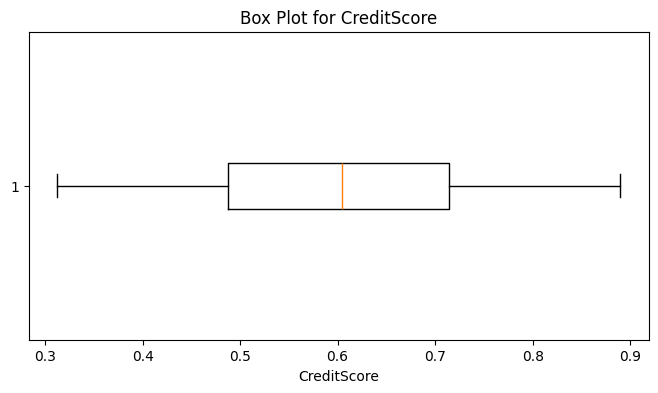

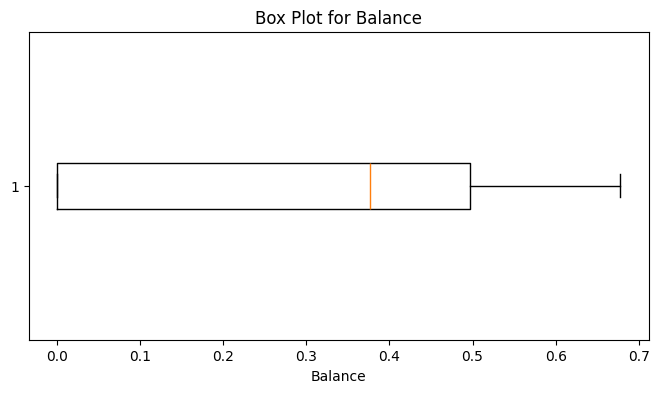

In [12]:
# Plot boxplots for feature inspection
for column in ['CreditScore', 'Balance']:
    plt.figure(figsize=(8, 4))
    plt.boxplot(df[column], vert=False)
    plt.title(f"Box Plot for {column}")
    plt.xlabel(column)
    plt.show()


In [13]:
# ----------- Random Forest --------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)  # Specify random_state for reproducibility
rf.fit(X_train_scaled, y_train)
y_pre_rf = rf.predict(X_test_scaled)

cm_rf = confusion_matrix(y_test, y_pre_rf)
print(f"RF Accuracy: {accuracy_score(y_test, y_pre_rf) * 100:.2f}%")
print("f1 score = ", f1_score(y_test, y_pre_rf, average='macro') * 100)
print("recall score = ", recall_score(y_test, y_pre_rf, average='macro') * 100)
print("precision score = ", precision_score(y_test, y_pre_rf, average='macro') * 100)
print("confusion matrix:")
print(cm_rf)
print("-------------------------------------------------------")


RF Accuracy: 90.62%
f1 score =  90.61775699785439
recall score =  90.62306653539282
precision score =  90.61370204480262
confusion matrix:
[[1059  110]
 [ 104 1009]]
-------------------------------------------------------


In [14]:
# ----------- SVM --------------------
svm = SVC(C=10, kernel='rbf', gamma='scale', random_state=42)  # Adjust kernel and hyperparameters as needed
svm.fit(X_train_scaled, y_train)
y_pre_svm = svm.predict(X_test_scaled)

cm_svm = confusion_matrix(y_test, y_pre_svm)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pre_svm) * 100:.2f}%")
print("f1 score = ", f1_score(y_test, y_pre_svm, average='macro') * 100)
print("recall score = ", recall_score(y_test, y_pre_svm, average='macro') * 100)
print("precision score = ", precision_score(y_test, y_pre_svm, average='macro') * 100)
print("confusion matrix:")
print(cm_svm)
print("-------------------------------------------------------")


SVM Accuracy: 85.19%
f1 score =  85.18131712745225
recall score =  85.2935638157647
precision score =  85.43791967414649
confusion matrix:
[[947 222]
 [116 997]]
-------------------------------------------------------


In [15]:
# ----------- KNN --------------------
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train_scaled, y_train)
y_pre_knn = knn.predict(X_test_scaled)

cm_knn = confusion_matrix(y_test, y_pre_knn)
print(f"KNN Accuracy: {accuracy_score(y_test, y_pre_knn) * 100:.2f}%")
print("f1 score = ", f1_score(y_test, y_pre_knn, average='macro') * 100)
print("recall score = ", recall_score(y_test, y_pre_knn, average='macro') * 100)
print("precision score = ", precision_score(y_test, y_pre_knn, average='macro') * 100)
print("confusion matrix:")
print(cm_knn)
print("-------------------------------------------------------")


KNN Accuracy: 82.87%
f1 score =  82.78441984419844
recall score =  83.08477384852935
precision score =  83.95755630865156
confusion matrix:
[[ 867  302]
 [  89 1024]]
-------------------------------------------------------


In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

y_train_numeric = pd.factorize(y_train)[0]

# Compute class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}


# Build the enhanced Neural Network model
nn_model = Sequential()
nn_model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.2))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(BatchNormalization())
nn_model.add(Dropout(0.3))

nn_model.add(Dense(1, activation='sigmoid'))

# Compile the model with an adjusted learning rate
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model
history = nn_model.fit(
    X_train_scaled, y_train_numeric,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print(f"Improved Test Loss: {loss:.4f}")
print(f"Improved Test Accuracy: {accuracy*100:.2f}%")

# Predict using the enhanced model
nn_y_pred = (nn_model.predict(X_test_scaled) > 0.5).astype('int32')

# Print evaluation metrics
print("\nEnhanced Neural Network Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, nn_y_pred))
print("F1 Score:", f1_score(y_test, nn_y_pred))
print("Recall Score:", recall_score(y_test, nn_y_pred))
print("Precision Score:", precision_score(y_test, nn_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, nn_y_pred))
print("\nClassification Report:\n", classification_report(y_test, nn_y_pred))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6648 - loss: 0.6611 - val_accuracy: 0.7726 - val_loss: 0.4890
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7472 - loss: 0.5289 - val_accuracy: 0.7862 - val_loss: 0.4563
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7601 - loss: 0.5073 - val_accuracy: 0.7923 - val_loss: 0.4440
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7519 - loss: 0.5103 - val_accuracy: 0.7945 - val_loss: 0.4449
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7624 - loss: 0.4936 - val_accuracy: 0.8019 - val_loss: 0.4396
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7792 - loss: 0.4746 - val_accuracy: 0.8050 - val_loss: 0.4369
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7756 - loss: 0.4793 - val_accuracy: 0.8072 - val_loss: 0.4325
Epoch 8/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7792 - loss: 0.4770 - val_ac